# Simulating real-time fMRI classification

In [32]:
#from delphi.networks.ConvNets import BrainStateClassifier3d
import nibabel as nib
import glob
import numpy as np
import os
from delphi.networks.ConvNets import BrainStateClassifier3d
from delphi.utils.plots import classification_timecourse, confusion_matrix
from delphi.utils.tools import z_transform, compute_accuracy
import torch
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.patches as mpatches

from captum.attr import GuidedBackprop
from zennit.rules import Epsilon, Gamma, Pass
from zennit.types import Convolution, Linear, Activation
from zennit.composites import LayerMapComposite
from delphi.utils.tools import save_in_mni
from utils.tools import attribute_with_method

composite_lrp_map = [
    (Activation, Pass()),
    (Convolution, Gamma(gamma=.25)),
    (Linear, Epsilon(epsilon=0)),
]

LRP = LayerMapComposite(
    layer_map=composite_lrp_map,
)
LRP.__name__ = 'LRP'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [36]:
#volume_model_path = "../04_volumetric_approach/models/vol-multitask-classifier-withrest_fold-00"
volume_model_path = "../05_volumetric_approach/models/vol-motor-classifier-withrest_fold-09"
#volume_model_path = "../04_volumetric_approach/models/vol-wm-classifier-withrest_fold-02"

t_model_path = "../04_transfer_learning//models/from-scratch/motor_samplesize-120_seed-1224_fold-05"

t_model = BrainStateClassifier3d(t_model_path).float()
t_model.eval();

volume_model = BrainStateClassifier3d(volume_model_path).float()
volume_model.eval();

Loading from config file ../04_transfer_learning//models/from-scratch/motor_samplesize-120_seed-1224_fold-05/config.yaml
Loading from config file ../05_volumetric_approach/models/vol-motor-classifier-withrest_fold-09/config.yaml


In [3]:
TASKID = "MOTOR"
PE = "LR" # RL

ev_files = sorted(glob.glob(os.path.join(f"/media/philippseidel/5tb/hcp_download/{TASKID}/logs/*_{PE}.txt")))
ev_files

['/media/philippseidel/5tb/hcp_download/MOTOR/logs/footleft_LR.txt',
 '/media/philippseidel/5tb/hcp_download/MOTOR/logs/footright_LR.txt',
 '/media/philippseidel/5tb/hcp_download/MOTOR/logs/handleft_LR.txt',
 '/media/philippseidel/5tb/hcp_download/MOTOR/logs/handright_LR.txt',
 '/media/philippseidel/5tb/hcp_download/MOTOR/logs/tongue_LR.txt']

In [7]:
labels = [volume_model.config["class_labels"][i].lower() for i in range(len(volume_model.config["class_labels"]))]

if TASKID == "WM":
    labels_of_interest = sorted(["body", "face", "place", "tool", f"rest_{TASKID.lower()}"])
if TASKID == "MOTOR":
    labels_of_interest = sorted(["handleft", "handright", "footright", "footleft", "tongue", f"rest_{TASKID.lower()}"])
if TASKID == "SOCIAL":
    labels_of_interest = sorted(["mental", "rnd", f"rest_{TASKID.lower()}"])
if TASKID == "RELATIONAL":
    labels_of_interest = sorted(["match", "relation", f"rest_{TASKID.lower()}"])
indices = [i for i, lbl in enumerate(labels) if lbl in labels_of_interest]
indices

[0, 1, 2, 3, 4, 5]

In [8]:
test_sub_fnames = glob.glob("../t-maps/test/body/sub*.nii.gz")
test_subs = [os.path.split(test_sub_fnames[i])[1][:9] for i in range(len(test_sub_fnames))]

In [67]:
def attribute_with_method(attributor_method, model, data, target):
    data.requires_grad = True

    attributor_name = str(attributor_method.__name__)

    if attributor_name == 'LRP':
        grad_dummy = torch.eye(model.config['n_classes'], device=torch.device("cpu"))[target]
        with attributor_method.context(model) as modified_model:
            output = modified_model(data)
            attribution, = torch.autograd.grad(output.squeeze(), data, grad_outputs=grad_dummy)

    elif attributor_name == 'GuidedBackprop':
        gbp = attributor_method(model)
        attribution = gbp.attribute(data, target)

    return attribution

In [ ]:
for s, sub in tqdm(enumerate(test_subs[:1]), desc="testsubs"):
    path2nifti = f"/media/philippseidel/5tb/hcp_download/{TASKID}/{sub}_{PE}.nii.gz"
    # load the data
    data = nib.load(path2nifti).get_fdata()
    data = np.nan_to_num(z_transform(data))
    
    data = torch.tensor(data)

In [108]:
attr = np.zeros_like(data)
for i in tqdm(range(data.size()[-1]), desc="volumes"):
    in_vol = data[:,:,:,i].unsqueeze(0).unsqueeze(0).float()
    attribution = attribute_with_method(LRP, volume_model, in_vol, real[i])

    attr[:,:,:,i] = attribution.squeeze().detach().numpy()


volumes:   0%|          | 0/284 [00:00<?, ?it/s]

In [109]:
save_in_mni(attr, "test.nii.gz")

Saving test.nii.gz


In [72]:
from nltools.data import Brain_Data
from delphi import mni_template

In [110]:
test = Brain_Data("test.nii.gz", mask=mni_template)

In [122]:
test.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), IntSlider(value=0, continuous_update=Fals…

In [18]:
for s, sub in tqdm(enumerate(test_subs), desc="testsubs"):
    path2nifti = f"/media/philippseidel/5tb/hcp_download/{TASKID}/{sub}_{PE}.nii.gz"
    # load the data
    data = nib.load(path2nifti).get_fdata()
    data = np.nan_to_num(z_transform(data))
    
    data = torch.tensor(data)
    
    if s == 0:
        predicted_volume = np.zeros((data.size()[-1], len(test_subs)))
        predicted_t = np.zeros_like(predicted_volume)
        
        probs_volume = np.zeros((data.size()[-1], volume_model.config["n_classes"], len(test_subs)))
        probs_t = np.zeros((data.size()[-1], t_model.config["n_classes"], len(test_subs)))
        
    for i in tqdm(range(data.size()[-1]), desc="volumes"):
        in_vol = data[:,:,:,i].unsqueeze(0).unsqueeze(0)

        # get the predictions for the model trained on volumes
        out = volume_model.SM(volume_model(in_vol.float()))
        probs_volume[i,:,s] = out.detach().cpu().numpy()
        predicted_volume[i,s] = np.argmax(probs_volume[i,:, s])
        
        # get the predictions for the model trained on t-maps
        out = t_model.SM(t_model(in_vol.float()))
        probs_t[i,:,s] = out.detach().cpu().numpy()
        predicted_t[i,s] = np.argmax(probs_t[i,:, s])        

testsubs: 0it [00:00, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

volumes:   0%|          | 0/284 [00:00<?, ?it/s]

### generate the volume wise real labels

In [49]:
real = np.zeros(data.shape[-1])
bold_lag = 5

ctr = 0
for i, ax in enumerate(labels_of_interest):
    if "rest" in labels_of_interest[i]:
        pass
    else:
        onset = np.ceil(pd.read_table(ev_files[ctr], header=None)/.72)
        for j, on in enumerate(onset[0].values):
            real[int(on+bold_lag):int(on+onset[1].values[0]+bold_lag)] = indices[i]+1
    
        ctr+=1

real[real==0] = np.squeeze(np.where(np.array(f"rest_{TASKID.lower()}") == np.array(labels)))+1
real = (real-1).astype(int)

In [50]:
real

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

### compute the accuracy for each subject

In [21]:
accs = np.zeros((len(test_subs), 2))

for i in range(len(test_subs)):
    accs[i, 0] = compute_accuracy(real, predicted_volume[:, i])
    accs[i, 1] = compute_accuracy(real, predicted_t[:, i])

accs

array([[0.68309859, 0.52816901],
       [0.66901408, 0.38380282],
       [0.82394366, 0.53169014],
       [0.66549296, 0.39084507],
       [0.69366197, 0.43309859],
       [0.71126761, 0.53873239],
       [0.77464789, 0.45070423],
       [0.75704225, 0.42253521],
       [0.66549296, 0.41197183],
       [0.65492958, 0.44366197],
       [0.67605634, 0.38732394],
       [0.75704225, 0.50704225],
       [0.78521127, 0.57746479],
       [0.70070423, 0.49647887],
       [0.62676056, 0.47535211],
       [0.63732394, 0.42605634],
       [0.6584507 , 0.39084507],
       [0.70070423, 0.41549296],
       [0.81338028, 0.54577465],
       [0.82042254, 0.5       ]])

In [22]:
# let's be more fair for the t-map trained NN and remove the rest parts
accs2 = np.zeros_like(accs)

real_cropped = real
real_cropped = np.delete(real_cropped, np.where(real==4))

for i in range(len(test_subs)):
    predicted_volume_cropped = predicted_volume[:, i]
    predicted_volume_cropped = np.delete(predicted_volume_cropped, np.where(real==4))
    predicted_t_cropped = predicted_t[:, i]
    predicted_t_cropped = np.delete(predicted_t_cropped, np.where(real==4))
    
    accs2[i, 0] = compute_accuracy(real_cropped, predicted_volume_cropped)
    accs2[i, 1] = compute_accuracy(real_cropped, predicted_t_cropped)

accs2

array([[0.65294118, 0.64705882],
       [0.65294118, 0.55882353],
       [0.93529412, 0.74117647],
       [0.65294118, 0.55294118],
       [0.76470588, 0.51176471],
       [0.78823529, 0.71176471],
       [0.9       , 0.68823529],
       [0.84117647, 0.63529412],
       [0.8       , 0.62941176],
       [0.63529412, 0.61764706],
       [0.77647059, 0.58235294],
       [0.87058824, 0.7       ],
       [0.85882353, 0.71764706],
       [0.8       , 0.67058824],
       [0.70588235, 0.68823529],
       [0.74705882, 0.58235294],
       [0.71176471, 0.53529412],
       [0.73529412, 0.52352941],
       [0.93529412, 0.78823529],
       [0.96470588, 0.73529412]])

In [25]:
print(f"Across subjects average classification accuracy over whole-time course for {TASKID} task trained on volumes:", accs2[:,0].mean(), "+/-", accs2[:,0].std()/np.sqrt(len(test_subs)), "(s.e.m)")
print(f"Across subjects average classification accuracy over whole-time course for {TASKID} task trained on tmaps:", accs2[:,1].mean(), "+/-", accs2[:,1].std()/np.sqrt(len(test_subs)), "(s.e.m)")

Across subjects average classification accuracy over whole-time course for MOTOR task trained on volumes: 0.786470588235294 +/- 0.02223692804454184 (s.e.m)
Across subjects average classification accuracy over whole-time course for MOTOR task trained on tmaps: 0.6408823529411765 +/- 0.01761504449008129 (s.e.m)


### conf-mat across all subjects

In [ ]:
real_vec = np.tile(real, len(test_subs))
pred_vec = predicted.flatten('F')

fig, ax = plt.subplots()
mat, _ = confusion_matrix(real_vec, pred_vec, model.config["class_labels"], ax=ax)

### show some classification time-course (average across all test-subjects)

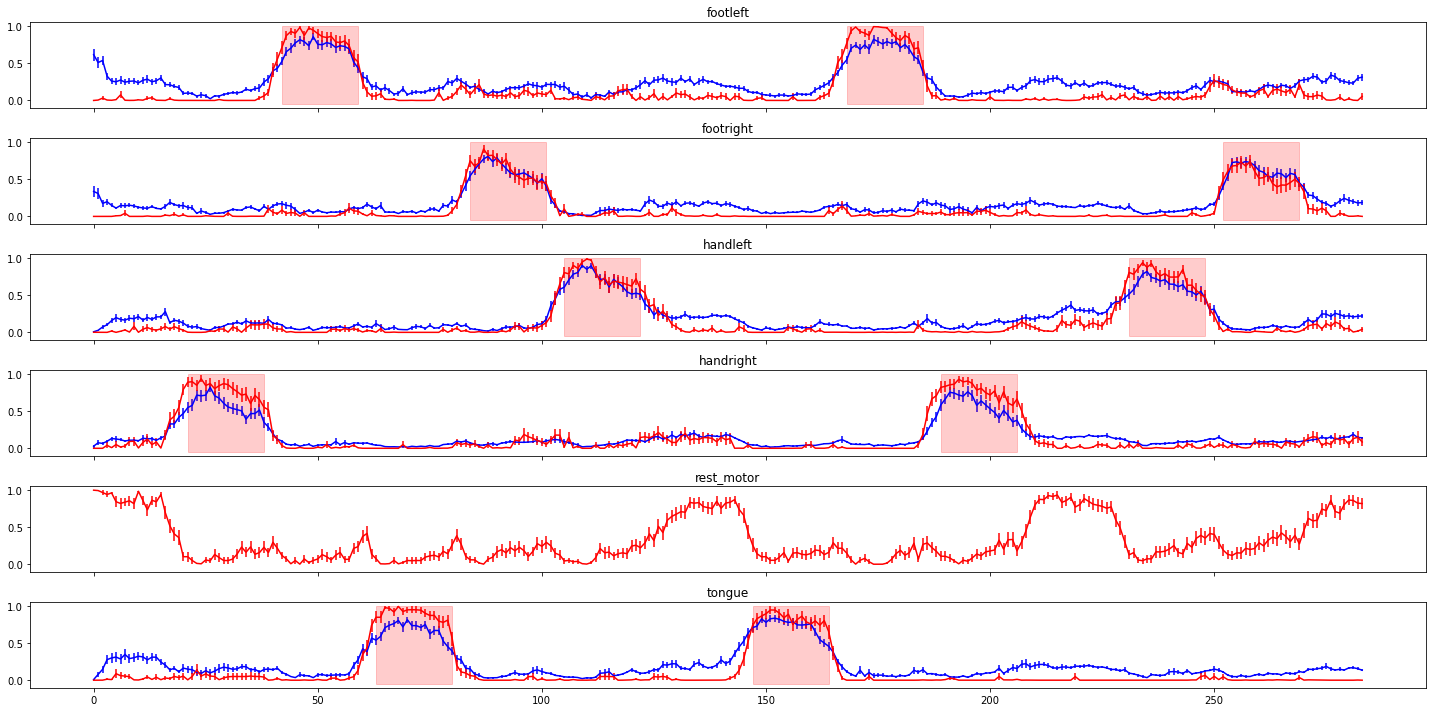

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(labels_of_interest),1, figsize=(20,10), sharex=True, sharey=True)

x = np.arange(len(predicted_t))*.72

# the HRF peaks at about 4-6 seconds after the stimulus onset.
bold_lag = 5

mu_t = probs_t.mean(axis=2)
sem_t = probs_t.std(axis=2)/np.sqrt(len(test_subs))

mu_vol = probs_volume.mean(axis=2)
sem_vol = probs_volume.std(axis=2)/np.sqrt(len(test_subs))

ctr = 0
for i, ax in enumerate(axes):
    #ax.plot(predicted==indices[i], linewidth=2)
    if i < 4:
        ax.errorbar(np.arange(len(mu_t)), mu_t[:, i], sem_t[:,i], color='blue', zorder=1)
    if i == 5:
        ax.errorbar(np.arange(len(mu_t)), mu_t[:, i-1], sem_t[:,i-1], color='blue', zorder=1)
    ax.errorbar(np.arange(len(mu_vol)), mu_vol[:, i], sem_vol[:,i], color='red', zorder=1)
    if "rest" in labels_of_interest[i]:
        pass
    else:
        onset = np.ceil(pd.read_table(ev_files[ctr], header=None)/.72)
        for j, on in enumerate(onset[0].values):
            rect=mpatches.Rectangle((on+bold_lag, -.05),onset[1].values[0], 1.05, 
                        fill = True, alpha=.2,
                        color = "red",
                        linewidth = 1)
            ax.add_patch(rect)
            #ax.axvline(on+bold_lag, color='r')
            #ax.axvline(on+onset[1].values[0]+bold_lag, color='r', linestyle="--")
        ctr+=1
    ax.set_title(labels_of_interest[i])

fig.tight_layout()

In [ ]:
probs